# Анализ распределения разницы между частотой в момент удара и прогноза окончания остывания

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

from fragment_iterator import fragment_iterator
from shot_detector import States

from halpers import load_all_logs_in_folder, f_aprox

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
folder = 'data'

global_series = load_all_logs_in_folder(folder)

print(f'Всего {len(global_series)} серий')

Всего 235 серий


## Распределение изменеий частот после выстрела

In [15]:
def get_freq_diffs(serie) -> list[float]:
    diffs = []
    for i, ts in enumerate(serie):
        generator = iter(ts)
        fragments = [f for f in fragment_iterator(generator, 0.85, 60)]
        for fragment_descr in fragments:
            fragment_start = fragment_descr['start'] # номер точки в исходном ряду
            raw_fragment = fragment_descr['y_origin']
            _min_index = np.argmin(raw_fragment) # индекс точки с минимальным значением
            _min = raw_fragment[_min_index]
            
            if _min_index > 0.5 * len(raw_fragment):
                continue

            y = [y - _min for y in raw_fragment[_min_index:]]    
            x = np.linspace(0, len(y) - 1, len(y))
            
            try:
                coeffs, _ = optimize.curve_fit(f_aprox, x, y, p0=[1, 1], check_finite=True, bounds=((0.5, 0.1), (1.5, 100.0)))
                dest_forecast = coeffs[0]
            except RuntimeError:
                continue

            diff = dest_forecast - (raw_fragment[0] - _min)
            if diff < 0.1:
                continue
            diffs.append(diff)
    return diffs

In [20]:
# гистограмма для значений diff
diffs = get_freq_diffs(global_series)

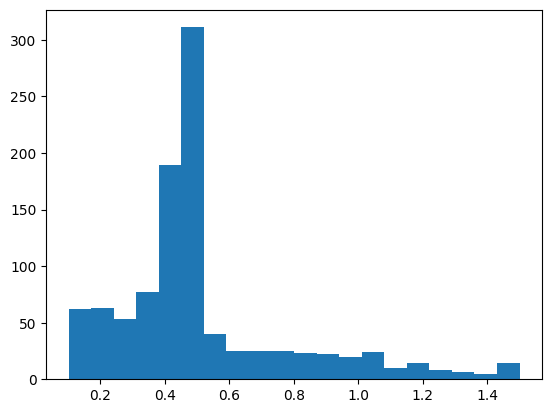

In [21]:

_ = plt.hist(diffs, bins=20)